# Cycles

Explains how I fit different cycles. Provides nice visuals.

In [ ]:
import aposch_functions as aposch

## Get df04_train dataset

In [ ]:
# read in data
data2019 = pd.read_csv('2019_RAW_APC_Data.csv.gz')

# get df04
df04 = aposch.clean_data(data2019)

# split into test/train sets
df04_train, df04_test = train_test_split(df04,
                                         test_size=0.2,
                                         random_state=19)

## Removing seasonal trend (sine/cosine curve)


Let's get started. Find the mean crowdedness by day (agnostic of station or of hour)

In [16]:
pw_agg_doy = df04_train.groupby(['DOY'])['passwithin'].mean()

cr_agg_doy = df04_train.groupby(['DOY'])['Crowded'].mean()

pw_agg_woy = df04_train.groupby(['WOY'])['passwithin'].mean()

cr_agg_woy = df04_train.groupby(['WOY'])['Crowded'].mean()

In [19]:
def sinu(x, a, c, d):
    b = 6.28/52 # forces the period to be 1 year)
    return a * np.sin(b * (x - c)) + d

params, params_covariance = optimize.curve_fit(sinu, pw_agg_woy.index, pw_agg_woy,
                                               p0=[3, 13, 33])

Text(0.5, 0, 'Week of year')

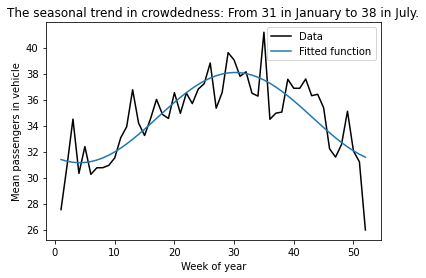

In [26]:
x_data = pw_agg_woy.index
y_data = pw_agg_woy
y_sinu_year = pd.Series(data=sinu(x_data, params[0], params[1], params[2]),
                   index=x_data)


plt.figure(figsize=(6, 4))
plt.plot(x_data, y_data, label='Data', c='black')
plt.plot(x_data, y_sinu_year,
         label='Fitted function')
plt.title('The seasonal trend in crowdedness: From 31 in January to 38 in July.')
plt.legend(loc='best')
plt.ylabel('Mean passengers in vehicle')
plt.xlabel('Week of year')


In [27]:
pw_agg_woy.name = 'WkMeanPassw'
y_sinu_year.name = 'Sinu01Passw'

Now plot the daily crowdedness minus the year-period curve.

Need to first get a reference table of which year corresponds to which day...

In [28]:
ref = df04[['DOY','WOY']].drop_duplicates(['DOY','WOY'])
ref = ref.set_index('DOY')

In [29]:
byday = ref.copy()
byday['DayMeanPassw'] = pw_agg_doy

In [30]:
byday = byday.join(pw_agg_woy, on='WOY')
byday = byday.join(y_sinu_year, on='WOY')

In [31]:
byday['Removed01'] = byday['DayMeanPassw'] - byday['Sinu01Passw']

Text(0.5, 1.0, 'After removing the year-period trend, a week-period cycle remains.')

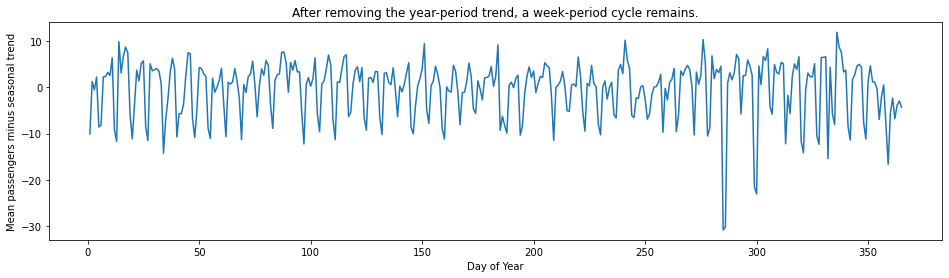

In [34]:
plt.figure(figsize=(16,4))
plt.plot(byday['Removed01'])
plt.xlabel('Day of Year')
plt.ylabel('Mean passengers minus seasonal trend')
plt.title('After removing the year-period trend, a week-period cycle remains.')

In [356]:
byday['Date'] = pd.date_range("2019-01-01", periods=365, freq="D")
byday['DOW'] = byday['Date'].dt.day_of_week
byday

,WOY,DayMeanPassw,WkMeanPassw,Sinu01Passw,Removed01,Date,DOW
DOY,,,,,,,
1,1,21.335422,27.538416,31.390687,-10.055265,2019-01-01,1
2,1,32.596526,27.538416,31.390687,1.205839,2019-01-02,2
3,1,30.782498,27.538416,31.390687,-0.608189,2019-01-03,3
4,1,33.555050,27.538416,31.390687,2.164363,2019-01-04,4
5,1,22.818011,27.538416,31.390687,-8.572676,2019-01-05,5
...,...,...,...,...,...,...,...
361,52,29.238619,25.975936,31.574381,-2.335762,2019-12-27,4
362,52,24.764120,25.975936,31.574381,-6.810261,2019-12-28,5
363,52,27.697143,25.975936,31.574381,-3.877238,2019-12-29,6


October 26-27 and October 12-13 were the big dips in passengers. Oct 12-13 was Columbus/Indigenous Weekend. Don't know what Oct 26-27 was.

In [368]:
# take the by-day df and group by day of week
bydow = pd.DataFrame()
bydow['DowMeanOfR01'] = byday.groupby('DOW')['Removed01'].mean()
bydow['Trend02'] = np.where(bydow.index<5, np.mean(bydow.loc[:5,'DowMeanOfR01']),
                            np.mean(bydow.loc[5:,'DowMeanOfR01']))

In [370]:
bydow

,DowMeanOfR01,Trend02
DOW,,
0,0.836258,0.841765
1,1.095074,0.841765
2,2.30452,0.841765
3,2.99001,0.841765
4,3.725138,0.841765
5,-5.900413,-7.403647
6,-8.906882,-7.403647


Text(0.5, 1.0, 'This is the average week-period cycle. Weekends have fewer passengers than weekdays.')

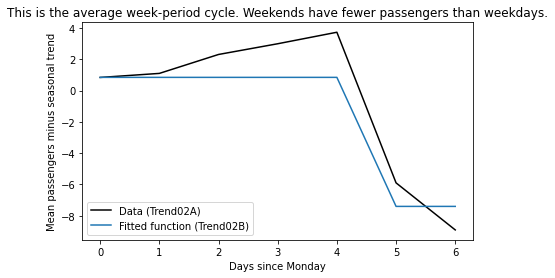

In [389]:


plt.figure(figsize=(7,4))
plt.plot(bydow['DowMeanOfR01'], label='Data (Trend02A)', c='black')
plt.plot(bydow['Trend02'],
         label='Fitted function (Trend02B)')
plt.legend(loc='best')
plt.xlabel('Days since Monday')
plt.ylabel('Mean passengers minus seasonal trend')
plt.title('This is the average week-period cycle. Weekends have fewer passengers than weekdays.')

Try both removing the black trend and removing the blue trend from the dataset. (Done at end of section.)

See what each of these looks like if you remove it from the 365-day plot.

In [375]:
dow_trends = bydow.copy()
dow_trends.columns = ['Trend02A','Trend02B']

In [382]:
byday = byday.join(dow_trends, on='DOW')
byday['Removed02A'] = byday['Removed01'] - byday['Trend02A']
byday['Removed02B'] = byday['Removed01'] - byday['Trend02B']

Text(0.5, 1.0, 'From Removed01, remove a day-specific week-period trend (Trend02A). By eye, noise remains. Perhaps holidays.')

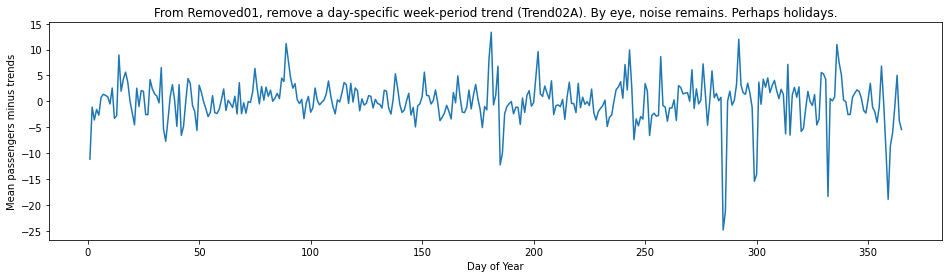

In [390]:
plt.figure(figsize=(16,4))
plt.plot(byday['Removed02A'])
plt.xlabel('Day of Year')
plt.ylabel('Mean passengers minus trends')
plt.title('From Removed01, remove a day-specific week-period trend (Trend02A). By eye, noise remains. Perhaps holidays.')

Text(0.5, 1.0, 'From Removed01, remove a day-specific week-period trend (Trend02B). By eye, a week-period trend remains.')

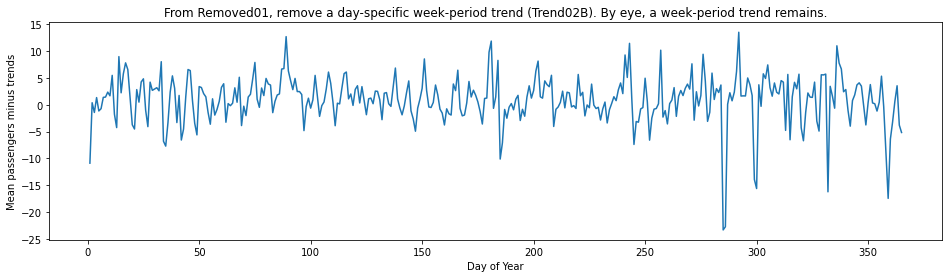

In [391]:
plt.figure(figsize=(16,4))
plt.plot(byday['Removed02B'])
plt.xlabel('Day of Year')
plt.ylabel('Mean passengers minus trends')
plt.title('From Removed01, remove a day-specific week-period trend (Trend02B). By eye, a week-period trend remains.')

Looking at the two plots above, I prefer the former.

##### Come back to the below later...

- I started to remove a week-period sinusoidal trend, but then I decided that wasn't appropriate.

def sinu(x, a, c, d):
    b = 6.28/7 # forces the period to be 1 week
    return a * np.sin(b * (x - c)) + d

params, params_covariance = optimize.curve_fit(sinu, byday.index, byday['Removed01'],
                                               p0=[, 98, 0])

x_data = pw_agg_woy.index
y_data = pw_agg_woy
y_sinu_year = pd.Series(data=sinu(x_data, params[0], params[1], params[2]),
                   index=x_data)


plt.figure(figsize=(6, 4))
plt.plot(x_data, y_data, label='Data', c='black')
plt.plot(x_data, y_sinu_year,
         label='Fitted function')

plt.legend(loc='best')

pw_agg_woy.name = 'WkMeanPassw'
cw_agg_woy.name = 'WkAvgCrowded'


#### Create all these variables in df04_train. Call it df05_train.

In [379]:
df05_train = df04_train.copy()
df05_train = df05_train.join(y_sinu_year, on='WOY')  # column name 'Sinu01Passw'
df05_train = df05_train.join(dow_trends, on='DOW')
df05_train['Removed01'] = df05_train['passwithin'] - df05_train['Sinu01Passw']
df05_train['Removed02A'] = df05_train['Removed01'] - df05_train['Trend02A']
df05_train['Removed02B'] = df05_train['Removed01'] - df05_train['Trend02B']

df05_train has all the same observations as df04_train, just with extra features.
- 'Sinu01Passw' is the year-period sinu curve for passwithin
- 'Removed01' is the actual passwithin minus the sinu curve value of that week.
- 'Trend02A' is the week-period day-grain trend
- 'Trend02B' is the week-period coarse (weekday/weekend) trend
- 'Removed02A'
- 'Removed02B'